# Assignment 2
## Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 2D keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

In the following lines we provide a simple solution. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
+ To develop a better solution by changing the baseline model.
+ To increase performance by using several tricks :
    + Data augmentation: flipped images, greylevel image editing, etc. You can explore the Keras image augmentation layers https://keras.io/api/layers/preprocessing_layers/image_augmentation/
    + SGD: Changing learning rate and momentum over time.
    + Training: Using regularization techniques such as Dropout.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.
+ To transform your solution in a Fully Convolutional Network (FCN) to make it independent of the input image size!


> You will need **GPU computation**. Consider the use of Colab!
    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.
+ How you have implemented the FCN (including one inference example).

The final model can be developed in Tensorflow or in Keras.

In [1]:
# downloading data

%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
!wget https://www.dropbox.com/s/svrvpus93131m98/test.csv
!wget https://www.dropbox.com/s/xzm5f5vrx6jwqui/training.csv

# These files are also available in campus virtual

--2022-11-29 12:09:56--  https://www.dropbox.com/s/svrvpus93131m98/test.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/svrvpus93131m98/test.csv [following]
--2022-11-29 12:09:57--  https://www.dropbox.com/s/raw/svrvpus93131m98/test.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc28fb1adf21455410e115ab4716.dl.dropboxusercontent.com/cd/0/inline/BxovxDsBkettVyKFmKH1HHJo_x1IOH8VXeoaRqI4Nwk9SykQGm5pWPlsOZDM0ee323_pMhyvn9uK1z_NknB-FPf8Q65kh50JiT--OSu-19w6dx407rsTsPnjt6UlgAnRjtXfzmoZ1M7FzJsCxqxzDvZ6iw1pHFTMfrumfUIIOSzd_A/file# [following]
--2022-11-29 12:09:57--  https://uc28fb1adf21455410e115ab4716.dl.dropboxusercontent.com/cd/0/inline/BxovxDsBkettVyKFmKH1HHJo_x1IOH8VXeoaRqI4Nwk9SykQGm5pWPlsOZDM0ee323_pMhyvn9uK1z_NknB-FPf8Q65k

In [2]:
# loading data

FTRAIN = 'training.csv'
FTEST = 'test.csv'
FLOOKUP = 'IdLookupTable.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    print("There are missing points:")
    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X.reshape(df.shape[0],96,96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.   
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

There are missing points:
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_li

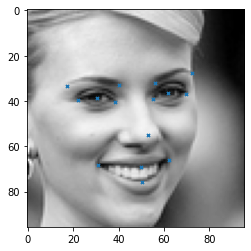

In [3]:
# loading data and checking it

X, y = load()
plot_sample(X[12],y[12])

In [4]:
# Split the initial training dataset into training, validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

print(x_train.shape)

(1498, 96, 96, 1)


In [ ]:
x_test.shape

(321, 96, 96, 1)

##Data Augmentation

In [5]:
from scipy.ndimage.filters import gaussian_filter

numImg = x_train.shape[0]
numExt = 6
new_X = np.ndarray(shape=(x_train.shape[0]*numExt, x_train.shape[1], x_train.shape[2]))
new_y = np.ndarray(shape=(y_train.shape[0]*numExt, y_train.shape[1]))
columns = ["left_eye_center_x", "left_eye_center_y", "right_eye_center_x", "right_eye_center_y", "left_eye_inner_corner_x", "left_eye_inner_corner_y", "left_eye_outer_corner_x", "left_eye_outer_corner_y", "right_eye_inner_corner_x", "right_eye_inner_corner_y", "right_eye_outer_corner_x", "right_eye_outer_corner_y", "left_eyebrow_inner_end_x", "left_eyebrow_inner_end_y", "left_eyebrow_outer_end_x", "left_eyebrow_outer_end_y", "right_eyebrow_inner_end_x", "right_eyebrow_inner_end_y", "right_eyebrow_outer_end_x", "right_eyebrow_outer_end_y", "nose_tip_x", "nose_tip_y", "mouth_left_corner_x", "mouth_left_corner_y", "mouth_right_corner_x", "mouth_right_corner_y", "mouth_center_top_lip_x", "mouth_center_top_lip_y", "mouth_center_bottom_lip_x", "mouth_center_bottom_lip_y"]   

flipX = np.array([(-1)**(i+1) for i in range(30)])
flipY = np.array([(-1)**(i) for i in range(30)])

# dataset augmentation
for i in range(numImg):
  img = np.squeeze(x_train[i, :, :])
  tgt = y_train[i, :]

  #original
  new_X[i, :, :] = img
  new_y[i, :] = tgt

  #blurred - gaussian filter is used for blurred
  new_X[i+numImg, :] = gaussian_filter(img, sigma=2)
  new_y[i+numImg, :] = tgt

  #brighter
  new_X[i+numImg*2, :, :] = (img + 1)/2
  new_y[i+numImg*2, :] = tgt

  #darker
  new_X[i+numImg*3, :, :] = img/2
  new_y[i+numImg*3, :] = tgt

  #flipped
  new_X[i+numImg*4, :, :] = np.fliplr(img)
  auxY = np.multiply(flipX, tgt)
  # flip labels
  left_ix = [i for (i, el) in enumerate(columns) if 'left' in el]
  right_ix = [i for (i, el) in enumerate(columns) if 'right' in el]
  auxY[left_ix], auxY[right_ix] = auxY[right_ix], auxY[left_ix]
  new_y[i+numImg*4, :] = auxY


  # data dropout (images are 96x96, so a 10% noise is around 900 pixels)
  num_replaced = 900
  indices_x = np.random.randint(0, img.shape[0], num_replaced)
  indices_y = np.random.randint(0, img.shape[1], num_replaced)
  auxX = np.copy(img)
  auxX[indices_x, indices_y] = 0
  new_X[i+numImg*5, :, :] = auxX
  new_y[i+numImg*5, :] = tgt



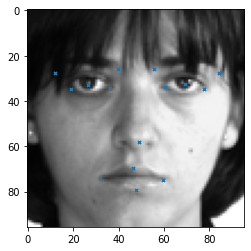

In [64]:
# checking data augmentation (original)
plot_sample(new_X[12], new_y[12])

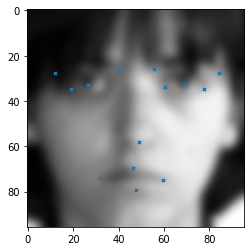

In [65]:
# blurred
plot_sample(new_X[12 + numImg], new_y[12 + numImg])

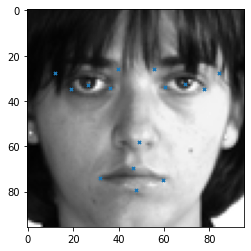

In [66]:
# brighter
plot_sample(new_X[12 + numImg*2], new_y[12 + numImg*2])

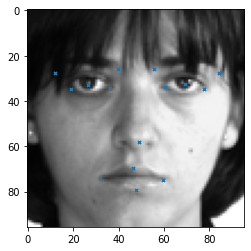

In [67]:
# darker
plot_sample(new_X[12 + numImg*3], new_y[12 + numImg*3])

In [6]:
# Repeat samples in order to augment the training set even more
new_X = np.concatenate((new_X, new_X, new_X), axis=0)
new_y = np.concatenate((new_y, new_y, new_y), axis=0)
print(new_X.shape)

(26964, 96, 96)


### Keras Data Augmentation

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

input_shape = (96, 96, 1)

data_augmentation = keras.Sequential([
    #layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
     #                                            input_shape),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Predefined parameters
input_shape = (None, None, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),#data_augmentation #keras.Input(shape=(None,), dtype="int32")
        layers.Conv2D(16, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        #layers.GlobalAveragePooling2D(),
        #layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(90, activation="relu"),
        layers.Dense(output_shape, activation="tanh"),
    ]
)

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, None, None, 16)    416       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, None, None, 16)   0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, None, None, 32)    4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, None, None, 32)   0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, None, None, 64)    18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, None, None, 64)  

### Model - Convolutional Neural Network (MNIST)

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),#data_augmentation #keras.Input(shape=(None,), dtype="int32")
        layers.Conv2D(16, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(90, activation="relu"),
        layers.Dense(output_shape, activation="tanh"),
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 96, 96, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                        

In [8]:
batch_size = 16
epochs = 10 #50

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss=root_mean_squared_error, optimizer="adam") #optimizer = "sgd"

model.fit(new_X, new_y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10
1517/1517 [==============================] - 19s 7ms/step - loss: 0.0525 - val_loss: 0.0357
Epoch 2/10
1517/1517 [==============================] - 9s 6ms/step - loss: 0.0328 - val_loss: 0.0281
Epoch 3/10
1517/1517 [==============================] - 9s 6ms/step - loss: 0.0273 - val_loss: 0.0250
Epoch 4/10
1517/1517 [==============================] - 10s 7ms/step - loss: 0.0248 - val_loss: 0.0226
Epoch 5/10
1517/1517 [==============================] - 9s 6ms/step - loss: 0.0233 - val_loss: 0.0208
Epoch 6/10
1517/1517 [==============================] - 9s 6ms/step - loss: 0.0224 - val_loss: 0.0201
Epoch 7/10
1517/1517 [==============================] - 10s 7ms/step - loss: 0.0217 - val_loss: 0.0194
Epoch 8/10
1517/1517 [==============================] - 9s 6ms/step - loss: 0.0211 - val_loss: 0.0194
Epoch 9/10
1517/1517 [==============================] - 10s 6ms/step - loss: 0.0207 - val_loss: 0.0187
Epoch 10/10
1517/1517 [==============================] - 10s 6ms/step - loss: 

In [9]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

11/11 [==============================] - 0s 9ms/step
Mean pixel error:  1.3134615


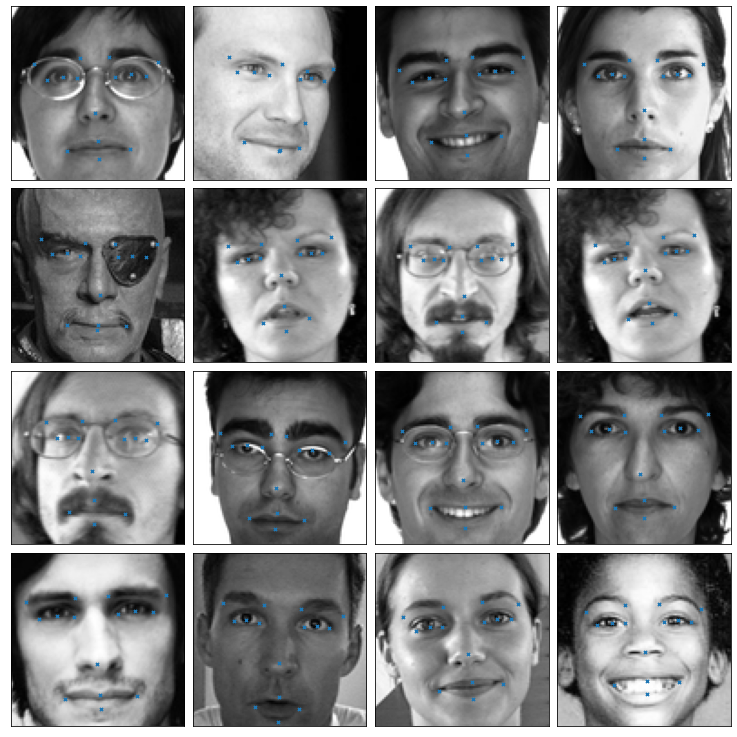

In [10]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new[i])
pyplot.show()

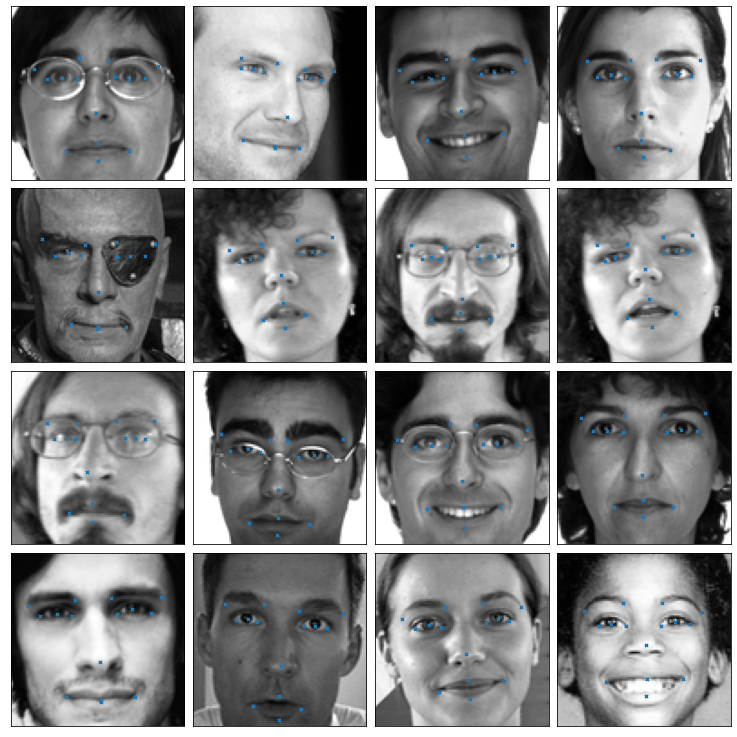

In [11]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_valid[i])

pyplot.show()

### Fully Convolutional Neural Network (MNIST)

In [25]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Predefined parameters
input_shape = (None, None, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),#data_augmentation #keras.Input(shape=(None,), dtype="int32")
        layers.Conv2D(16, kernel_size=(5, 5), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.GlobalAveragePooling2D(),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(90, activation="relu"),
        layers.Dense(output_shape, activation="tanh"),
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, None, None, 16)    416       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, None, None, 16)   0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, None, None, 32)    4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, None, None, 32)   0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, None, None, 64)    18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, None, None, 64)  

In [38]:
batch_size = 16
epochs = 50 #50

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss=root_mean_squared_error, optimizer="adam") #optimizer = "sgd"

model.fit(new_X, new_y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
1517/1517 [==============================] - 10s 6ms/step - loss: 0.0298 - val_loss: 0.0250
Epoch 2/50
1517/1517 [==============================] - 9s 6ms/step - loss: 0.0294 - val_loss: 0.0241
Epoch 3/50
1517/1517 [==============================] - 9s 6ms/step - loss: 0.0292 - val_loss: 0.0239
Epoch 4/50
1517/1517 [==============================] - 9s 6ms/step - loss: 0.0290 - val_loss: 0.0241
Epoch 5/50
1517/1517 [==============================] - 9s 6ms/step - loss: 0.0285 - val_loss: 0.0234
Epoch 6/50
1517/1517 [==============================] - 9s 6ms/step - loss: 0.0283 - val_loss: 0.0235
Epoch 7/50
1517/1517 [==============================] - 9s 6ms/step - loss: 0.0282 - val_loss: 0.0236
Epoch 8/50
1517/1517 [==============================] - 9s 6ms/step - loss: 0.0280 - val_loss: 0.0232
Epoch 9/50
1517/1517 [==============================] - 9s 6ms/step - loss: 0.0278 - val_loss: 0.0233
Epoch 10/50
1517/1517 [==============================] - 9s 6ms/step - loss: 0.02

In [39]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

11/11 [==============================] - 0s 3ms/step
Mean pixel error:  1.4859115


# Reporting

Please, report the results of your experiments in this cell.

## What is the best result you got when testing?  

> Results must be evaluated by computing the **mean error in pixel units**. If you get a mean error of 1.6 pixels is ok. If your get 1.5 is very good. If you get 1.4 or less, it is an outstanding result!

**Answer**: The mean pixel error is <b>1.3282626</b>

## What architecture and tricks you used for that result?
### Describe your design strategy as well all those tricks that contributed to your result.

**Answer**: The first change that i attempted was adding one more layer and therefore increasing the depth of the model. So, the model with 3 layers decreased the mean error: 1.76.

Then, i decided to reduce the batch size and i got a mean error 1.68.

After that i proceed to data augmantation for the training set. Flipped images to the dataset too.

Hence, having increased the training dataset i tried to improve the model a little bit. I created a Convolutional Neural Network and added even more layers. A dropout was used only for the training dataset. Then, i started playing a little bit with the Kernel sizes of the Conv layers.

Evenmore, adding a Dropout layer in our model gave us an even better overall result.

Then, i deduced even more data by adding dropout in the training data, setting 900 random points to 0.

Then I tried to check if other optimizers would lead to better results. SGD gave us worst results compared to the adam optimizer, so we kept the adam optimizer.

Finally, i reduced the number of epochs as i observed that with even more epochs the mean arror wasn't reducing dramatically. That's pretty much what i have tried in order to get a good result of approximately 1.33.

## What is the architecture of your FCN?

The final FCN network that we desinged consists of 10 layers. To be more specific, the first layer is a Convolutional layer with a 5x5 kernel size combined with a MaxPooling. Then the next 3 layers are Convolutional layers with 3x3 kernel size combined as well with a MaxPooling. The fifth layer consists of a GlobalAveragePooling2D() layer, which is actually the only difference between the CNN and FCN. The next layers consist of a Flatten layer and the seventh of a Dropout layer. Last but not least, the last two layers of our FCN are Desnes layers.





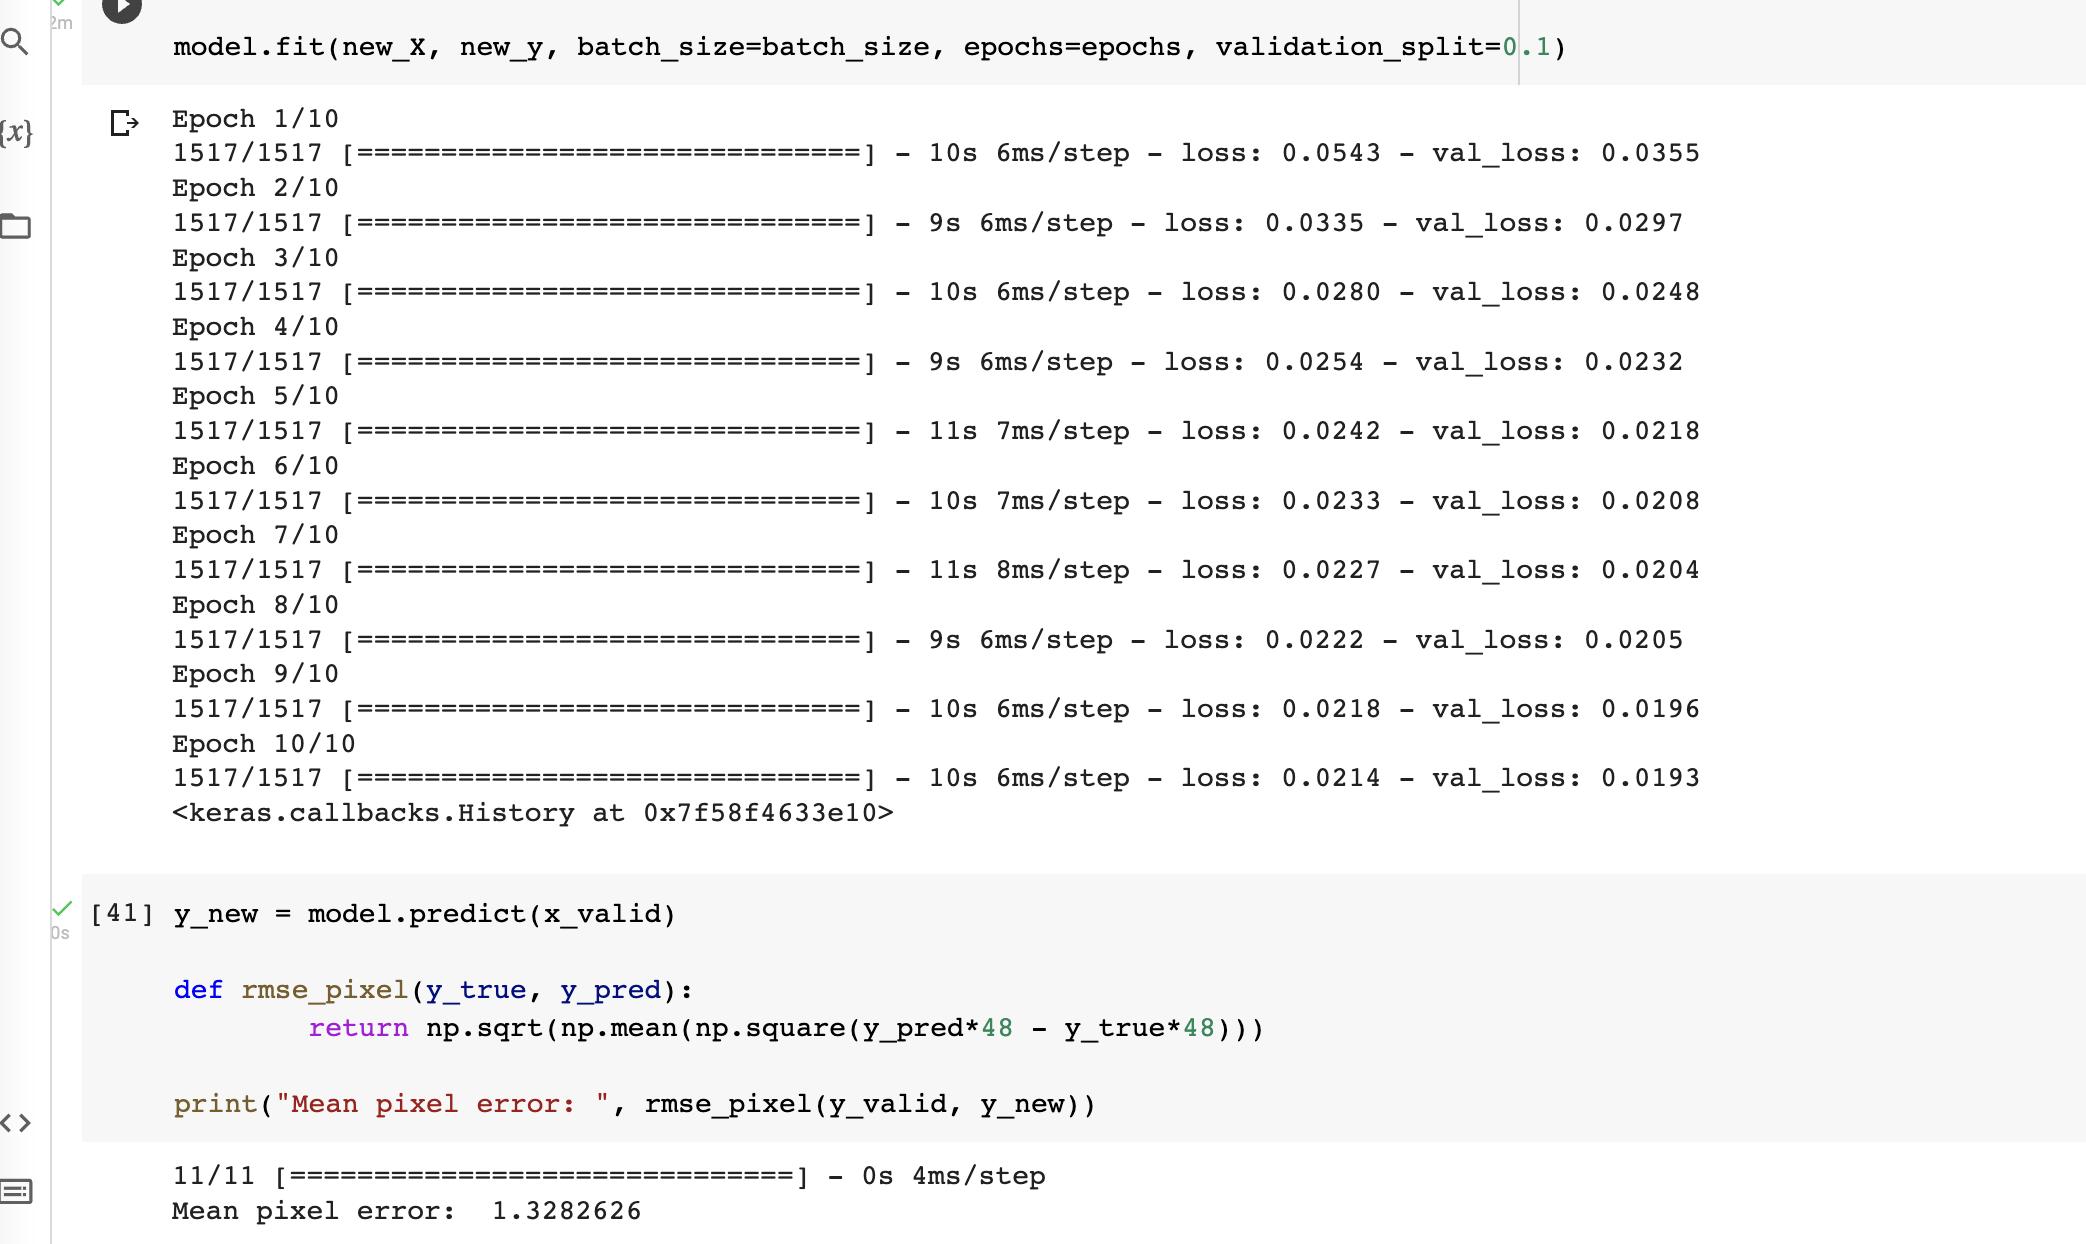

### Insert one of the test images in a larger image and show the detection result. The size of the face cannot change!

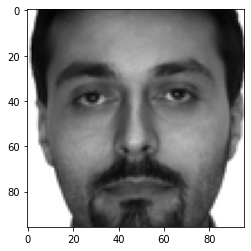

In [40]:
# Plot a test image
x_test_img = np.squeeze(x_test[0, :, :])
y_test_img = y_test[0, :]
pyplot.imshow(x_test_img, cmap='gray')

In [41]:
x_test_img = np.ndarray(shape=(x_test.shape[0], x_test.shape[1], x_test.shape[2]))
y_test_img = np.ndarray(shape=(y_test.shape[0], y_test.shape[1]))

for i in range(0, len(x_test)):
  x_test_img[i] = np.squeeze(x_test[i, :, :])
  y_test_img[i] = y_test[i, :]

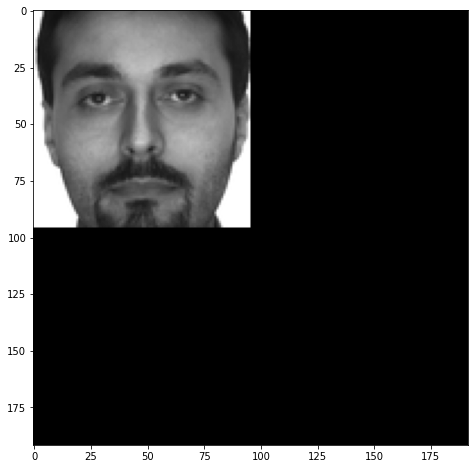

In [42]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

x_larger = np.ndarray(shape=(x_test.shape[0], x_test.shape[1]*2, x_test.shape[2]*2))

new_image_height = 192
new_image_width = 192

i=0

for img in x_test_img:
  # load resized image as grayscale
  h, w = img.shape
  #print(h,w)

  # load background image as grayscale
  back = np.full((new_image_height,new_image_width), 0, dtype=np.float32)
  hh, ww = back.shape
  #print(hh,ww)

  # compute xoff and yoff for placement of upper left corner of resized image   
  yoff = 0#round((hh-h)/2)
  xoff = 0#round((ww-w)/2)
  #print(yoff,xoff)

  # use numpy indexing to place the resized image in the center of background image
  x_larger[i] = back.copy()
  x_larger[i, yoff:yoff+h, xoff:xoff+w] = img #255

  #print(x_larger[48,48])
  i = i + 1

# view result
pyplot.figure(figsize = (8,8))
pyplot.imshow(x_larger[0], cmap='gray')

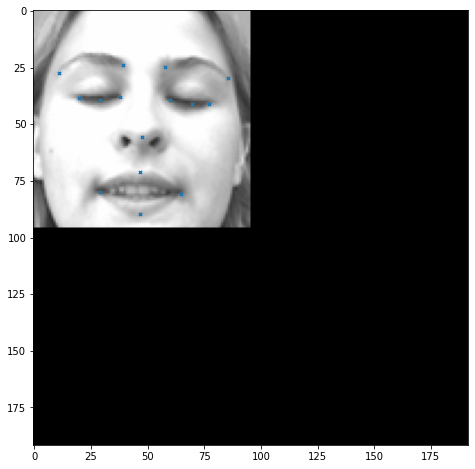

In [43]:
pyplot.figure(figsize = (8,8))
plot_sample(x_larger[30], y_test_img[30])

In [44]:
from numpy import zeros, newaxis
x_larger = x_larger[:, :, :, newaxis]
x_larger.shape

(321, 192, 192, 1)

In [45]:
y_larger = model.predict(x_larger)

11/11 [==============================] - 0s 8ms/step


In [46]:
def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_test_img[0], y_larger[0]))

Mean pixel error:  2.155341459853827


<Figure size 720x720 with 0 Axes>

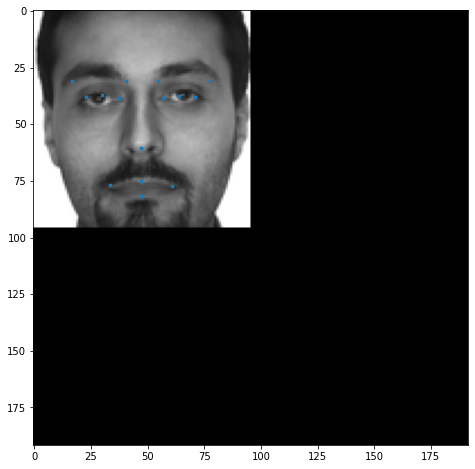

In [47]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(1):
    pyplot.figure(figsize = (8,8))
    #ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_larger[i,:,:,0],y_larger[i])
pyplot.show()